In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [2]:
dataset,info = tfds.load('oxford_iiit_pet',with_info=True)
print(dataset.keys())
print(info)
#우리는 이미지와 segmentation_mask만 사용해볼 예정 


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXYX2CU/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXYX2CU/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
dict_keys(['test', 'train'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 368

In [3]:
#전처리 과정으로 normalization, randomflip을 적용 
def random_flip(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask


def normalize(input_image,input_mask):
    input_image = tf.cast(input_image,tf.float32) / 255.0
    input_mask -= 1
    return input_image,input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'],(128,128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128), method='nearest')
    input_image ,input_mask = random_flip(input_image,input_mask)
    input_image, input_mask = normalize(input_image,input_mask)

    return input_image,input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'],(128,128),method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128), method='nearest')
    input_image,input_mask = normalize(input_image,input_mask)

    return input_image,input_mask



In [4]:
train = dataset['train'].map(load_image_train,num_parallel_calls = tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [5]:
#전처리를 진행후 batch_size 는 64로 설정해서 training dataset과 test dataset을 만들어 준다.
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)


In [6]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']

def display_with_metrics(display_list, iou_list, dice_score_list):
    ''' displays a list of images/masks and overlays a list of IoU and Dice Score '''
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True) # sort in place
    
    display_string_list = [f"{class_names[idx]}: IoU: {iou} Dice Score: {dice_score}" for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)
    
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=['Image', 'True Maks'])


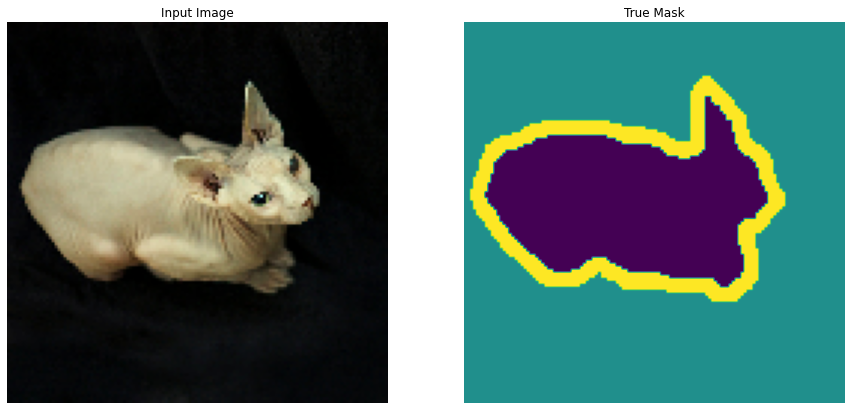

In [7]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [8]:
OUTPUT_CHANNELS =3 

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape = [128,128,3], include_top = False)

layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',               
 ]
layers = [base_model.get_layer(name).output for name in layer_names]
print(layers)
down_stack = tf.keras.Model(inputs = base_model.input,outputs=layers)
print(down_stack)
down_stack.trinable = False


9412608/9406464 [==============================] - 0s 0us/step
[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>, <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>, <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>, <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>, <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]


In [10]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
            pix2pix.upsample(512,3),
            pix2pix.upsample(256,3),
            pix2pix.upsample(128,3),
            pix2pix.upsample(64,3),
]

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.0 MB 8.4 MB/s 


In [11]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    x = inputs

    skips = down_stack(x)
    print(skips)
    print("")
    x = skips[-1]
    skips = reversed(skips[:-1])
    print(skips)

    for up, skip in zip(up_stack,skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])

    last = tf.keras.layers.Convolution2DTranspose(
        output_channels,3,strides=2,
        padding='same')
    x = last(x)

    return tf.keras.Model(inputs=inputs,outputs=x)



In [12]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'model')>, <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'model')>, <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'model')>, <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'model')>, <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'model')>]



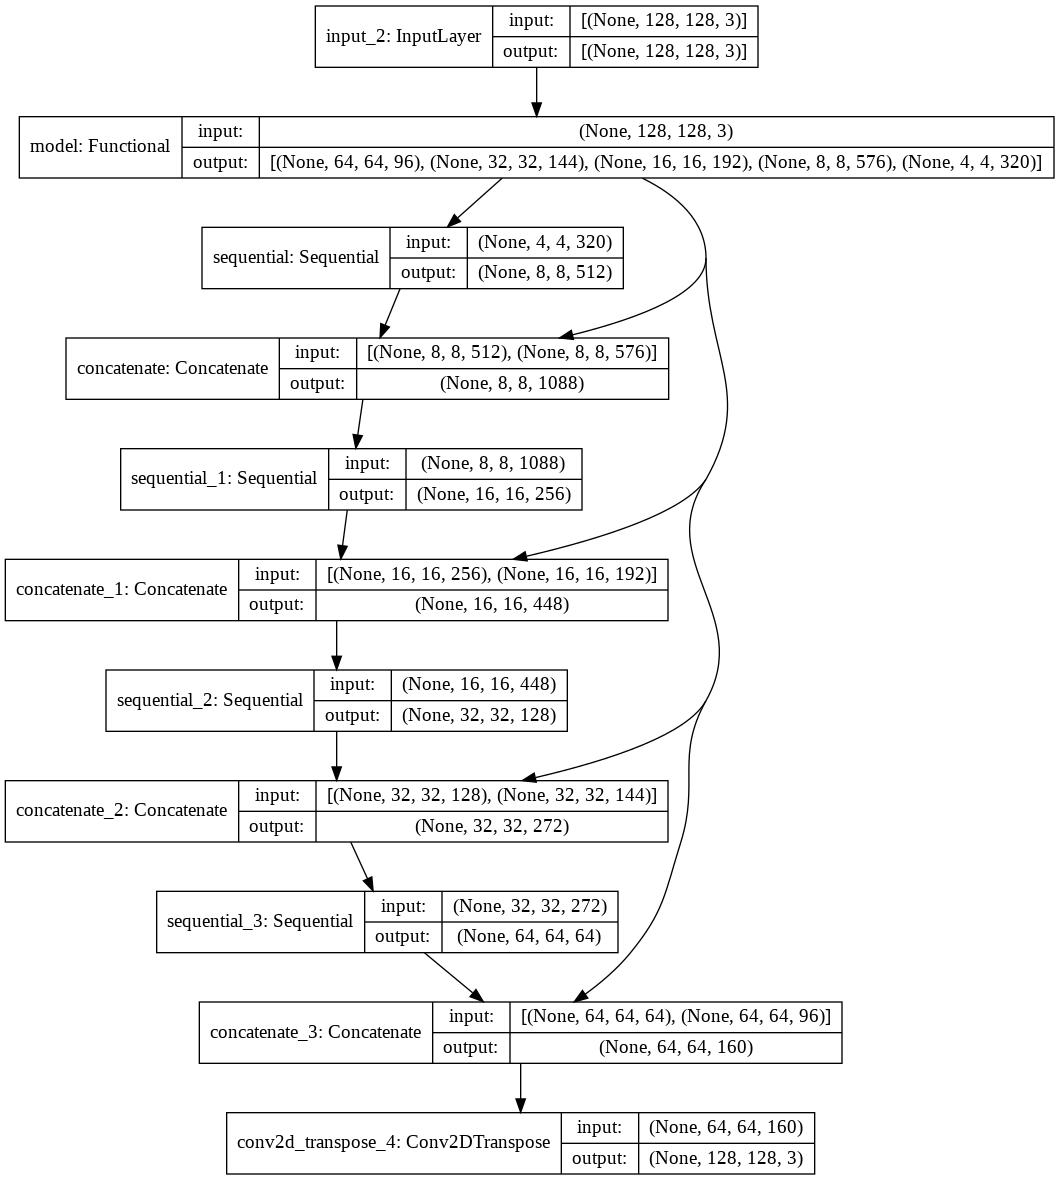

In [13]:
tf.keras.utils.plot_model(model,show_shapes=True)


In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis= -1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]

In [16]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

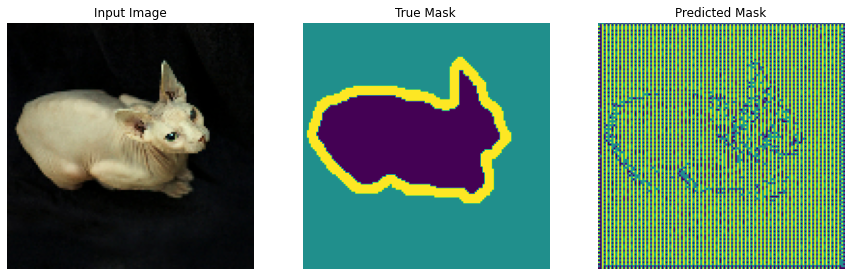

In [18]:
show_predictions()

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        #clear_output(wait=True)
        if epoch % 5 == 0:
            show_predictions()
            print('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

Epoch 1/20
57/57 [==============================] - 26s 297ms/step - loss: 0.4574 - accuracy: 0.8332 - val_loss: 2.1598 - val_accuracy: 0.5674


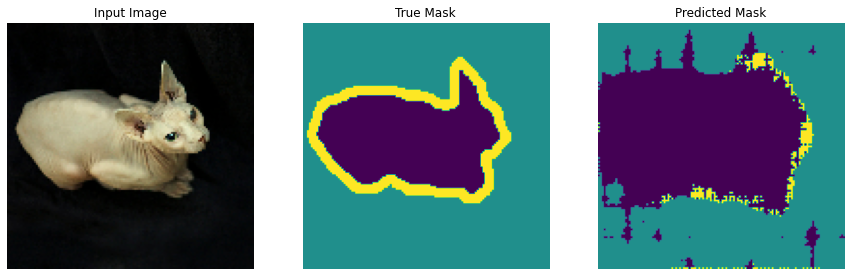


에포크 이후 예측 예시 1

Epoch 2/20
57/57 [==============================] - 16s 263ms/step - loss: 0.2527 - accuracy: 0.9046 - val_loss: 1.7507 - val_accuracy: 0.5027
Epoch 3/20
57/57 [==============================] - 15s 265ms/step - loss: 0.2113 - accuracy: 0.9180 - val_loss: 1.1264 - val_accuracy: 0.6126
Epoch 4/20
57/57 [==============================] - 15s 271ms/step - loss: 0.1904 - accuracy: 0.9244 - val_loss: 1.0591 - val_accuracy: 0.6276
Epoch 5/20
57/57 [==============================] - 16s 276ms/step - loss: 0.1789 - accuracy: 0.9283 - val_loss: 0.8263 - val_accuracy: 0.7298
Epoch 6/20
57/57 [==============================] - 16s 274ms/step - loss: 0.1712 - accuracy: 0.9308 - val_loss: 0.7796 - val_accuracy: 0.7167


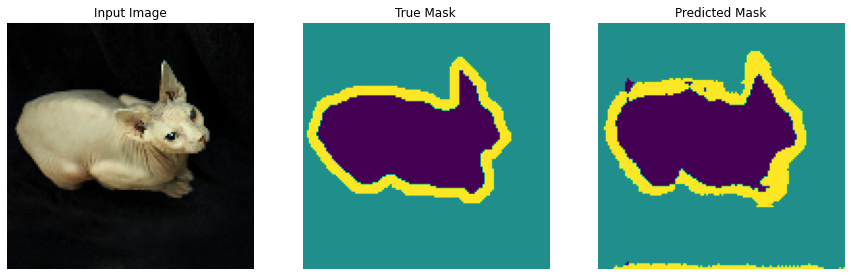


에포크 이후 예측 예시 6

Epoch 7/20
57/57 [==============================] - 15s 269ms/step - loss: 0.1796 - accuracy: 0.9276 - val_loss: 1.9637 - val_accuracy: 0.4923
Epoch 8/20
57/57 [==============================] - 15s 270ms/step - loss: 0.1604 - accuracy: 0.9341 - val_loss: 1.5543 - val_accuracy: 0.5826
Epoch 9/20
57/57 [==============================] - 15s 272ms/step - loss: 0.1457 - accuracy: 0.9396 - val_loss: 1.0322 - val_accuracy: 0.6706
Epoch 10/20
57/57 [==============================] - 15s 270ms/step - loss: 0.1409 - accuracy: 0.9415 - val_loss: 1.0378 - val_accuracy: 0.6690
Epoch 11/20
57/57 [==============================] - 16s 273ms/step - loss: 0.1383 - accuracy: 0.9422 - val_loss: 1.0712 - val_accuracy: 0.6770


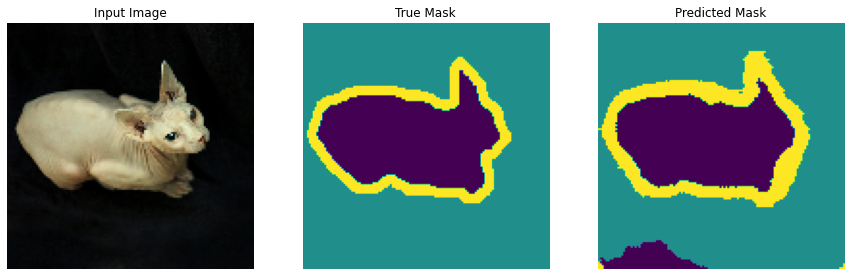


에포크 이후 예측 예시 11

Epoch 12/20
57/57 [==============================] - 15s 273ms/step - loss: 0.1308 - accuracy: 0.9452 - val_loss: 1.0938 - val_accuracy: 0.6694
Epoch 13/20
57/57 [==============================] - 16s 273ms/step - loss: 0.1224 - accuracy: 0.9487 - val_loss: 0.9842 - val_accuracy: 0.7150
Epoch 14/20
57/57 [==============================] - 15s 271ms/step - loss: 0.1203 - accuracy: 0.9494 - val_loss: 0.8321 - val_accuracy: 0.7454
Epoch 15/20
57/57 [==============================] - 15s 272ms/step - loss: 0.1161 - accuracy: 0.9510 - val_loss: 0.8574 - val_accuracy: 0.7550
Epoch 16/20
57/57 [==============================] - 15s 272ms/step - loss: 0.1120 - accuracy: 0.9527 - val_loss: 0.7334 - val_accuracy: 0.7906


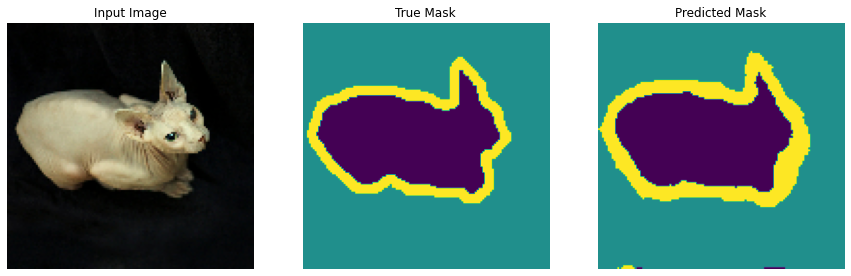


에포크 이후 예측 예시 16

Epoch 17/20
57/57 [==============================] - 15s 272ms/step - loss: 0.1522 - accuracy: 0.9386 - val_loss: 2.9709 - val_accuracy: 0.4526
Epoch 18/20
57/57 [==============================] - 15s 270ms/step - loss: 0.1503 - accuracy: 0.9379 - val_loss: 2.0832 - val_accuracy: 0.5263
Epoch 19/20
57/57 [==============================] - 15s 271ms/step - loss: 0.1256 - accuracy: 0.9472 - val_loss: 1.3219 - val_accuracy: 0.6540
Epoch 20/20
57/57 [==============================] - 15s 271ms/step - loss: 0.1131 - accuracy: 0.9522 - val_loss: 1.1673 - val_accuracy: 0.7090


In [20]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

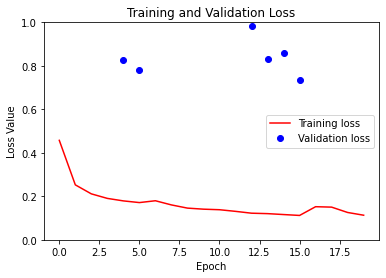

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

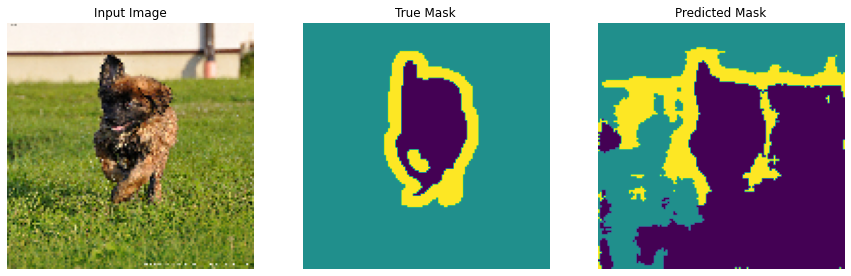

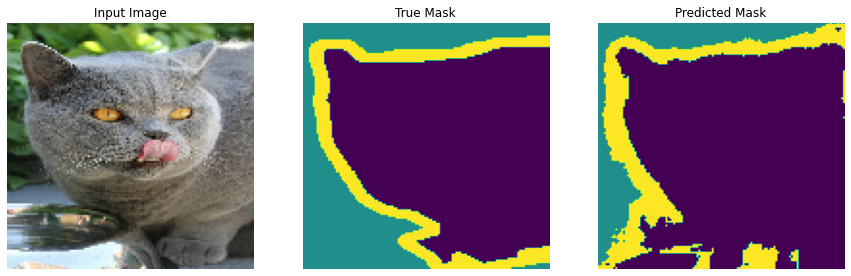

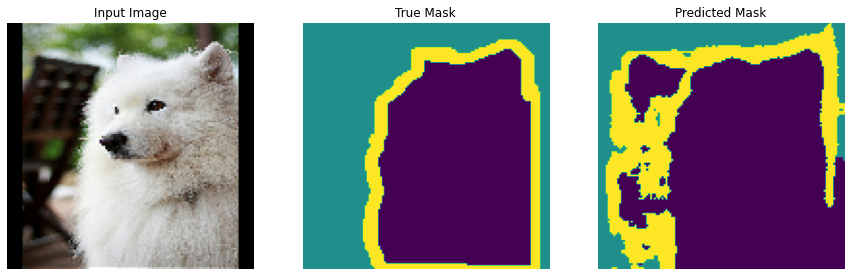

In [28]:
show_predictions(test_dataset, 3)